In [ ]:

from unet0 import UNet as UNet0
from unet1 import UNet as UNet1
from unet2 import UNet as UNet2



redes=[UNet0, UNet1, UNet2]
redes[1](4)

In [1]:

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_2dpre import POCVoxelConfig as cfg
from poc_config_2dpre import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss





from unet0 import UNet as UNet0
from unet1 import UNet as UNet1
from unet2 import UNet as UNet2

groupmodel=[]

redes=[UNet0, UNet1, UNet2]
num_classes=4

for i in range(3):

    shape_cp= r'C:\Users\admin\Desktop\cnn-facies-classifier-master\RESULTADOS_EQM\CHANNEL'+ format(i)+ r'\TRAIN_2D\model.dat'
    shape_cp = torch.load(shape_cp)
    model= redes[i](num_classes)
    #print(shape_cp.keys())
    #state_dict_2d=shape_cp.state_dict()
    for key in list(shape_cp.keys()):
        #print(key)
        #print(shape_cp[key].shape)
        if shape_cp[key].dim()==4:
            #print(key)
            shape_cp[key] = shape_cp[key].unsqueeze(i-3)
            #print(shape_cp[key].shape)    
    
    shape_cp.popitem()
    shape_cp.popitem()
    #print(shape_cp.keys)
    model.load_state_dict(shape_cp, strict=False)
 
    groupmodel.append(model)
    
print(groupmodel[0])


C:\Users\admin\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\admin\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\admin\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension
UNet(
  (enc1): _EncoderBlock(
    (encode): Sequential(
      (0): Conv3d(1, 64, kernel_size=[1, 3, 3], stride=(1, 1, 1), padding=[0, 1, 1])
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=[1, 3, 3], stride=(1, 1, 1), padding=[0, 1, 1])
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (enc2): _EncoderBlock(
    (encode): Sequential(
      (0): Conv3d(64, 128, kernel_size=[1, 3, 3], stride=(1, 1, 1), padding=[0, 1, 1])
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)


In [2]:
# encoding: utf-8
#POC 2,5D unet pre trained



import _init_paths

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_2dpre import POCVoxelConfig as cfg
from poc_config_2dpre import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss

import timeit
start_time = timeit.default_timer()

canal =2
def main(save_path=cfg.save, 
         n_epochs=cfg.n_epochs, 
         seed=cfg.seed
         ):
    if seed is not None:
        set_seed(cfg.seed)
    cudnn.benchmark = True



    # # Models
    os.makedirs(save_path,exist_ok = True)
    #copy_file_backup(save_path)
    redirect_stdout(save_path)

    # Datasets
    train_data = env.data_train
    test_data = env.data_train
    shape_cp = env.shape_checkpoint
    #val_data=env.data_test



    train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
    valid_set = None
    test_set = BaseDatasetVoxel(test_data, cfg.train_samples)

    model = groupmodel[canal]



    
    print(model)
    torch.save(model.state_dict(), os.path.join(save_path, format(canal)+ 'model.dat'))
    # Train the model
    train(model=model, train_set=train_set, valid_set=valid_set, test_set=test_set, save=save_path, n_epochs=n_epochs)
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
    print('Done!')



def train(model, train_set, test_set, save, valid_set, n_epochs):


    # Data loaders
    train_loader = DataLoader(train_set, batch_size=cfg.train_batch_size, shuffle=True,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    test_loader = DataLoader(test_set, batch_size=cfg.test_batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = DataLoader(valid_set, batch_size=cfg.batch_size, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
    # Model on cuda
    model = to_device(model)

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=cfg.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.milestones,
                                                     gamma=cfg.gamma)

    # Start log
    logs = ['loss', 'iou', 'dice'] + ['iou{}'.format(i) for i in range(4)]+['dice{}'.format(i) for i in range(4)]
    train_logs = ['train_'+log for log in logs]
    test_logs = ['test_'+log for log in logs]
    log_dict = OrderedDict.fromkeys(train_logs+test_logs, 0)
    with open(os.path.join(save, 'logs.csv'), 'w') as f:
        f.write('epoch,')
        for key in log_dict.keys():
            f.write(key+',')
        f.write('\n')
    writer = SummaryWriter(log_dir=os.path.join(save, 'Tensorboard_Results'))

    # Train model
    best_dice = 0

    for epoch in range(n_epochs):
        os.makedirs(os.path.join(cfg.save, 'canal_{}'.format(canal)),exist_ok = True)
        train_meters = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer,
            epoch=epoch,
            n_epochs=n_epochs,
            writer=writer
        )
        # if (epoch+1)%5==0:
        test_meters = test_epoch(
            model=model_wrapper,
            loader=test_loader,
            epoch=epoch,
            is_test=True,
            writer = writer
        )
        scheduler.step()

        # Log results
        for i, key in enumerate(train_logs):
            log_dict[key] = train_meters[i]
        for i, key in enumerate(test_logs):
            log_dict[key] = test_meters[i]

        log_results(save, epoch, log_dict, writer=writer)

        if cfg.save_all:
            torch.save(model.state_dict(), os.path.join(save, 'canal_{}'.format(canal), 'model.dat'))

        if log_dict['test_dice'] > best_dice:
            torch.save(model.state_dict(), os.path.join(save,'canal_{}'.format(canal), 'model.dat'))
            best_dice = log_dict['test_dice']
            print('New best dice: %.4f' % log_dict['test_dice'])
            #print(2.*intersection/union)
        else:
            print('Current best dice: %.4f' % best_dice)
            #print(2.*intersection/union)
    writer.close()

    with open(os.path.join(save, 'logs.csv'), 'a') as f:
        f.write(',,,,best dice,%0.5f\n' % (best_dice))
    # Final test of the best model on test set
    print('best dice: ', best_dice)

iteration = 0

def train_epoch(model, loader, optimizer, epoch, n_epochs, print_freq=1, writer=None):
    meters = MultiAverageMeter()
    # Model on train mode
    model.train()
    global iteration
    end = time.time()
    for batch_idx, (x, y) in enumerate(loader):
        # Create vaiables
        x = to_var(x)
        y = to_var(y)
        # compute output
        pred_logit = model(x)
        loss = soft_dice_loss(pred_logit, y, smooth=1e-2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y = y.long()
        
        batch_size = y.size(0)
        iou = cal_batch_iou(pred_logit, y)
        dice = cal_batch_dice(pred_logit, y)

        logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                            [iou[i].item() for i in range(len(iou))]+ \
                            [dice[i].item() for i in range(len(dice))]+ \
                            [time.time() - end]
        meters.update(logs, batch_size)   
        writer.add_scalar('train_loss_logs', loss.item(), iteration)
        with open(os.path.join(cfg.save, 'loss_logs.csv'), 'a') as f:
            f.write('%09d,%0.6f,\n'%((iteration + 1),loss.item(),))
        iteration += 1


        # measure elapsed time
        end = time.time()
        # print stats
        print_freq = 2 // meters.val[-1] + 1
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
            ])
            print(res)

    return meters.avg[:-1] #intersection, union


def test_epoch(model, loader, epoch, print_freq=1, is_test=True, writer=None):
    meters = MultiAverageMeter()
    # Model on eval mode
    model.eval()
    gt_classes = []
    pred_all_probs = []
    end = time.time()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            
            x = to_var(x)
            
            
            y = to_var(y)
            
            pred_logit = model(x)
            
            # calculate metrics
            pred_class = pred_logit.max(dim=1)[1]
            pred_probs = pred_logit.softmax(-1)
            pred_all_probs.append(pred_probs.cpu())
            gt_classes.append(y.cpu())
            
            #print(gt_classes.shape) #pred_class[20,48,48,48]
            #print(pred_probs[1]) #y e pred_probs[20,6,48,48,48]
            
            batch_size, n_classes = pred_logit.shape[:2]
            

            loss = soft_dice_loss(pred_logit, y, smooth=1e-2)
            y = y.long()
            batch_size = y.size(0)
            iou = cal_batch_iou(pred_logit, y)
            dice = cal_batch_dice(pred_logit, y)
 
            logs = [loss.item(), iou[1:].mean(), dice[1:].mean()]+ \
                                [iou[i].item() for i in range(len(iou))]+ \
                                [dice[i].item() for i in range(len(dice))]+ \
                                [time.time() - end]
            meters.update(logs, batch_size)

            end = time.time()

            print_freq = 2 // meters.val[-1] + 1
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (meters.val[-1], meters.avg[-1]),
                    'Loss %.4f (%.4f)' % (meters.val[0], meters.avg[0]),
                    'IOU %.4f (%.4f)' % (meters.val[1], meters.avg[1]),
                    'DICE %.4f (%.4f)' % (meters.val[2], meters.avg[2]),
                ])
                print(res)

    return meters.avg[:-1]

#if __name__ == '__main__':
    #fire.Fire(main)
main()


add code root path (with `mylib`, 'acsconv').
UNet(
  (enc1): _EncoderBlock(
    (encode): Sequential(
      (0): Conv3d(1, 64, kernel_size=[3, 3, 1], stride=(1, 1, 1), padding=[1, 1, 0])
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=[3, 3, 1], stride=(1, 1, 1), padding=[1, 1, 0])
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (enc2): _EncoderBlock(
    (encode): Sequential(
      (0): Conv3d(64, 128, kernel_size=[3, 3, 1], stride=(1, 1, 1), padding=[1, 1, 0])
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(128, 128, kernel_size=[3, 3, 1], stride=(1, 1, 1), padding=[1, 1, 0])
      (4): BatchNorm3d(128, eps=1e-05, m

C:\Users\admin\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: [1/50]	Iter: [1/83]	Time 4.820 (4.820)	Loss 0.7623 (0.7623)	IOU 0.1105 (0.1105)	DICE 0.1936 (0.1936)
Epoch: [1/50]	Iter: [33/83]	Time 0.063 (0.207)	Loss 0.3788 (0.5067)	IOU 0.6264 (0.4793)	DICE 0.7460 (0.6215)
Test	Iter: [1/17]	Time 3.811 (3.811)	Loss 0.3732 (0.3732)	IOU 0.5933 (0.5933)	DICE 0.6661 (0.6661)
New best dice: 0.7753
Epoch: [2/50]	Iter: [1/83]	Time 3.519 (3.519)	Loss 0.2385 (0.2385)	IOU 0.7210 (0.7210)	DICE 0.8200 (0.8200)
Epoch: [2/50]	Iter: [33/83]	Time 0.064 (0.168)	Loss 0.2066 (0.2318)	IOU 0.7373 (0.7199)	DICE 0.8325 (0.8195)
Epoch: [2/50]	Iter: [65/83]	Time 0.064 (0.116)	Loss 0.1825 (0.2142)	IOU 0.7491 (0.7308)	DICE 0.8418 (0.8275)
Epoch: [2/50]	Iter: [83/83]	Time 0.050 (0.105)	Loss 0.1723 (0.2063)	IOU 0.7624 (0.7353)	DICE 0.8527 (0.8309)
Test	Iter: [1/17]	Time 3.505 (3.505)	Loss 0.2372 (0.2372)	IOU 0.7303 (0.7303)	DICE 0.8069 (0.8069)
New best dice: 0.8417
Epoch: [3/50]	Iter: [1/83]	Time 3.468 (3.468)	Loss 0.1689 (0.1689)	IOU 0.7655 (0.7655)	DICE 0.8551 (0.8551

Epoch: [18/50]	Iter: [1/83]	Time 3.435 (3.435)	Loss 0.0521 (0.0521)	IOU 0.9147 (0.9147)	DICE 0.9541 (0.9541)
Epoch: [18/50]	Iter: [34/83]	Time 0.062 (0.163)	Loss 0.0444 (0.0520)	IOU 0.9360 (0.9231)	DICE 0.9660 (0.9587)
Epoch: [18/50]	Iter: [67/83]	Time 0.062 (0.113)	Loss 0.0666 (0.0585)	IOU 0.8926 (0.9077)	DICE 0.9410 (0.9494)
Epoch: [18/50]	Iter: [83/83]	Time 0.049 (0.104)	Loss 0.0555 (0.0580)	IOU 0.9119 (0.9084)	DICE 0.9522 (0.9499)
Test	Iter: [1/17]	Time 3.578 (3.578)	Loss 0.0608 (0.0608)	IOU 0.9254 (0.9254)	DICE 0.9591 (0.9591)
Current best dice: 0.9551
Epoch: [19/50]	Iter: [1/83]	Time 3.479 (3.479)	Loss 0.0463 (0.0463)	IOU 0.9280 (0.9280)	DICE 0.9613 (0.9613)
Epoch: [19/50]	Iter: [31/83]	Time 0.068 (0.174)	Loss 0.0458 (0.0520)	IOU 0.9240 (0.9189)	DICE 0.9591 (0.9563)
Epoch: [19/50]	Iter: [33/83]	Time 0.064 (0.167)	Loss 0.0461 (0.0519)	IOU 0.9274 (0.9194)	DICE 0.9612 (0.9565)
Epoch: [19/50]	Iter: [61/83]	Time 0.068 (0.119)	Loss 0.0444 (0.0516)	IOU 0.9375 (0.9211)	DICE 0.9669 (0.957

Epoch: [34/50]	Iter: [67/83]	Time 0.061 (0.114)	Loss 0.0309 (0.0282)	IOU 0.9468 (0.9508)	DICE 0.9720 (0.9742)
Epoch: [34/50]	Iter: [69/83]	Time 0.060 (0.112)	Loss 0.0288 (0.0282)	IOU 0.9482 (0.9507)	DICE 0.9728 (0.9742)
Epoch: [34/50]	Iter: [83/83]	Time 0.050 (0.104)	Loss 0.0307 (0.0283)	IOU 0.9490 (0.9506)	DICE 0.9733 (0.9742)
Test	Iter: [1/17]	Time 3.565 (3.565)	Loss 0.0208 (0.0208)	IOU 0.9755 (0.9755)	DICE 0.9874 (0.9874)
Current best dice: 0.9756
Epoch: [35/50]	Iter: [1/83]	Time 3.522 (3.522)	Loss 0.0279 (0.0279)	IOU 0.9487 (0.9487)	DICE 0.9731 (0.9731)
Epoch: [35/50]	Iter: [31/83]	Time 0.067 (0.175)	Loss 0.0264 (0.0271)	IOU 0.9523 (0.9523)	DICE 0.9751 (0.9751)
Test	Iter: [1/17]	Time 3.627 (3.627)	Loss 0.0262 (0.0262)	IOU 0.9663 (0.9663)	DICE 0.9825 (0.9825)
Current best dice: 0.9756
Epoch: [36/50]	Iter: [1/83]	Time 3.509 (3.509)	Loss 0.0319 (0.0319)	IOU 0.9441 (0.9441)	DICE 0.9705 (0.9705)
Epoch: [36/50]	Iter: [34/83]	Time 0.062 (0.165)	Loss 0.0245 (0.0299)	IOU 0.9528 (0.9466)	DIC

C:\Users\admin\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 32, 32, 32]             640
       BatchNorm3d-2       [-1, 64, 32, 32, 32]             128
              ReLU-3       [-1, 64, 32, 32, 32]               0
            Conv3d-4       [-1, 64, 32, 32, 32]          36,928
       BatchNorm3d-5       [-1, 64, 32, 32, 32]             128
              ReLU-6       [-1, 64, 32, 32, 32]               0
         MaxPool3d-7       [-1, 64, 16, 16, 16]               0
     _EncoderBlock-8       [-1, 64, 16, 16, 16]               0
            Conv3d-9      [-1, 128, 16, 16, 16]          73,856
      BatchNorm3d-10      [-1, 128, 16, 16, 16]             256
             ReLU-11      [-1, 128, 16, 16, 16]               0
           Conv3d-12      [-1, 128, 16, 16, 16]         147,584
      BatchNorm3d-13      [-1, 128, 16, 16, 16]             256
             ReLU-14      [-1, 128, 16,

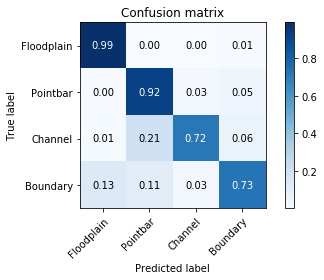

In [3]:
#2,5D evaluation

import _init_paths

import fire
import time
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
import sklearn
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from poc_dataset_ACS import BaseDatasetVoxel
from mylib.loss import soft_cross_entropy_loss
from mylib.utils import MultiAverageMeter, save_model, log_results, to_var, set_seed, \
        to_device, initialize, categorical_to_one_hot, copy_file_backup, redirect_stdout
from poc_config_2dpre import POCVoxelConfig as cfg
from poc_config_2dpre import POCVoxelEnv as env

from unet import UNet
from acsconv.models import ACSUNet
from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter

from mylib.metrics import cal_batch_iou, cal_batch_dice, AUROC_per_case
from mylib.loss import soft_dice_loss

import timeit
start_time = timeit.default_timer()
    
train_data = env.data_train
test_data = env.data_test

train_set = BaseDatasetVoxel(train_data, cfg.train_samples)
valid_set = None
test_set = BaseDatasetVoxel(test_data, cfg.test_samples)

#canal=0
PATH=r'C:\Users\admin\Desktop\cnn-facies-classifier-master\tmp\voxel\Conv2_5D_330samples\canal_' + format(canal) +'\model.dat'
print(PATH)

model = groupmodel[canal]
#model=redes[0](4)
model.load_state_dict(torch.load(PATH))
model = to_device(model)
true=[]
truepred=[]
test_loader = DataLoader(test_set, batch_size=1, shuffle=False,
                                pin_memory=(torch.cuda.is_available()), num_workers=cfg.num_workers)
from torchvision import models
from torchsummary import summary

summary(model,(1,32,32,32))
with torch.no_grad():
    for z,(x, y) in enumerate(test_loader):
        x = to_var(x)
        y = to_var(y)
            
        model.eval()
        predit = model(x)
        
        predit, y = predit.detach().cpu().numpy(), y.detach().cpu().numpy() 
        predit=np.argmax(predit,1)
        y=np.argmax(y,1)


        
        truepred.append(predit)
        true.append(y)
    
import matplotlib.pyplot as plt
import numpy as np
import h5py
import keras
import k3d
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,jaccard_score
from ipywidgets import interact, widgets

import src
true= np.concatenate(true).ravel()
truepred= np.concatenate(truepred).ravel()
precision = precision_score(true, truepred, average='weighted')
recall = recall_score(true, truepred, average='weighted')
f1 = f1_score(true, truepred, average='weighted')
jaccard=jaccard_score(true, truepred, average='weighted')

classnames = {
    0: 'Floodplain',
    1: 'Pointbar',
    2: 'Channel',
    3: 'Boundary',
}
matrix = confusion_matrix(true, truepred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

print(f'Precision: \t{precision}')
print(f'Recall: \t{recall}')
print(f'F1-Score: \t{f1}')
print(f'IOU: \t{jaccard}')
elapsed = timeit.default_timer() - start_time
print(f'elapsed:  \t {elapsed}')

src.plot_confusion_matrix(matrix, classnames.values(), title="Confusion matrix")     


In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(4, 2)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x

In [ ]:
from unet import UNet 
from unet1 import UNet1

from acsconv.converters import ACSConverter, Conv3dConverter, Conv2_5dConverter
groupmodels=[]
model=UNet(4)
for i in range(3):
    
    model2=Conv2_5dConverter(model,i-3)
    #model3=UNet1(4)
    #print(model2)
    print(i)
    print(model2)
    groupmodels.append(model2)
    
#print(groupmodels[0])

In [ ]:
model=UNet(4)

#model3=Conv2_5dConverter(model,-2)


#model2=Conv2_5dConverter(model)
state_dict_2d=model.state_dict()
for key in list(state_dict_2d.keys()):
    print(key)
    if state_dict_2d[key].dim()==4:
        print(state_dict_2d[key].shape)
        state_dict_2d[key] = state_dict_2d[key].unsqueeze(i-3)
        print(state_dict_2d[key].shape)
    #model.state_dict().update(state_dict_2d, strict=True)
    #print(model)

In [ ]:
from acsconv.operators import Conv2_5d
model=ACSUNet(4)
model2=UNet(4)
i=2
model2=Conv2_5dConverter(model2,i-3)
shape_cp= r'C:\Users\admin\Desktop\cnn-facies-classifier-master\RESULTADOS_EQM\CHANNEL'+ format(i)+ r'\TRAIN_2D\model.dat'
shape_cp = torch.load(shape_cp)
shape_cp.popitem()
shape_cp.popitem()
for key in list(shape_cp.keys()):
    #print(key)
    #print(shape_cp[key].shape)
    if shape_cp[key].dim()==4:
        #print(key)
        shape_cp[key] = shape_cp[key].unsqueeze(i-3)
        print(shape_cp[key].shape)
#print(shape_cp.keys)
#incompatible_keys = model2.load_state_dict(shape_cp, strict=False)
print(model2)